     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.6/172.6 kB 3.0 MB/s eta 0:00:00
[[0.19151945 0.62210877]
 [0.43772774 0.78535858]
 [0.77997581 0.27259261]
 ...
 [0.61855942 0.25061218]
 [0.58300501 0.83552332]
 [0.66329429 0.72830129]]


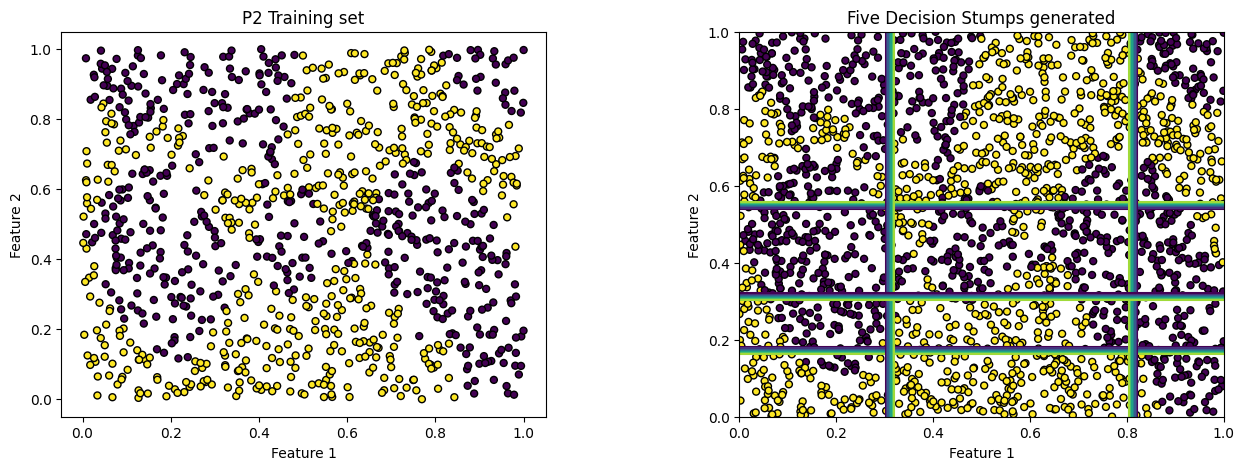

<Figure size 640x480 with 0 Axes>

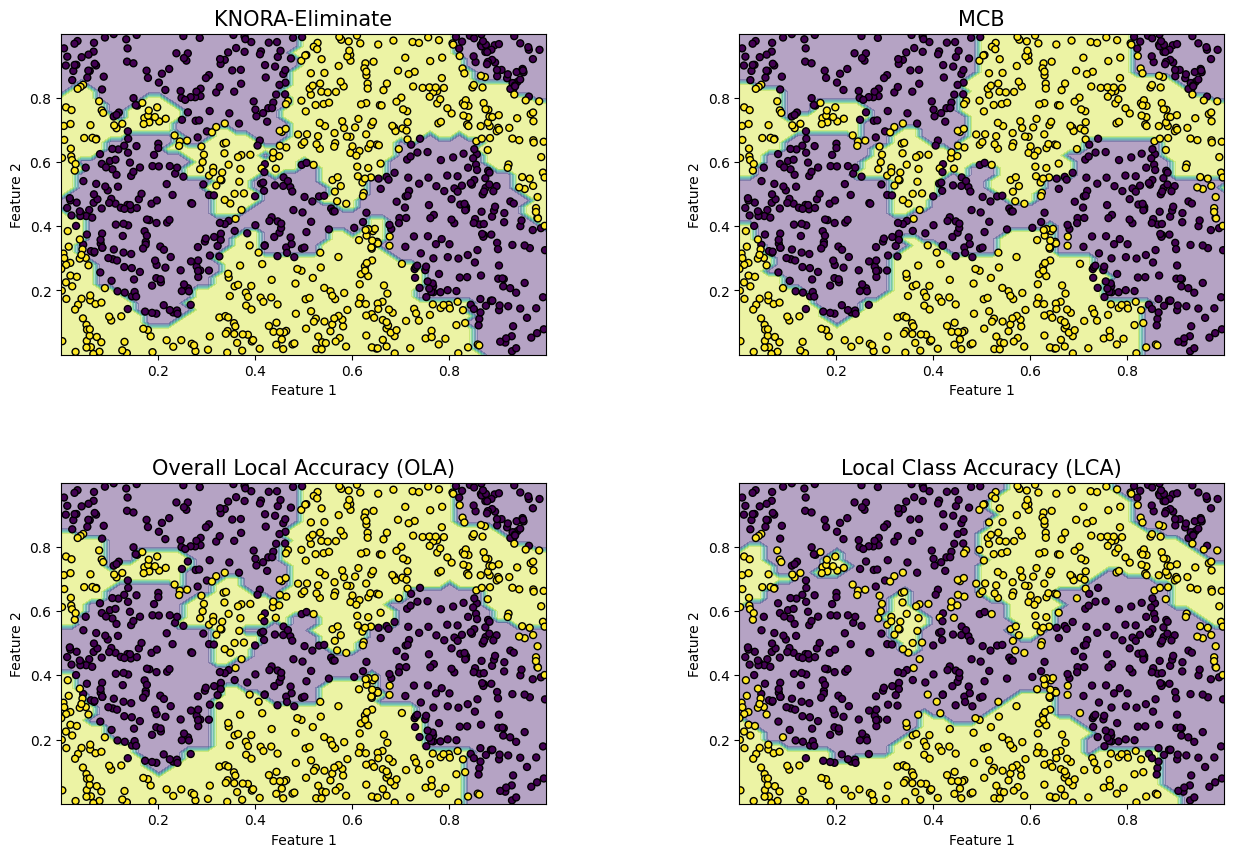

<Figure size 640x480 with 0 Axes>

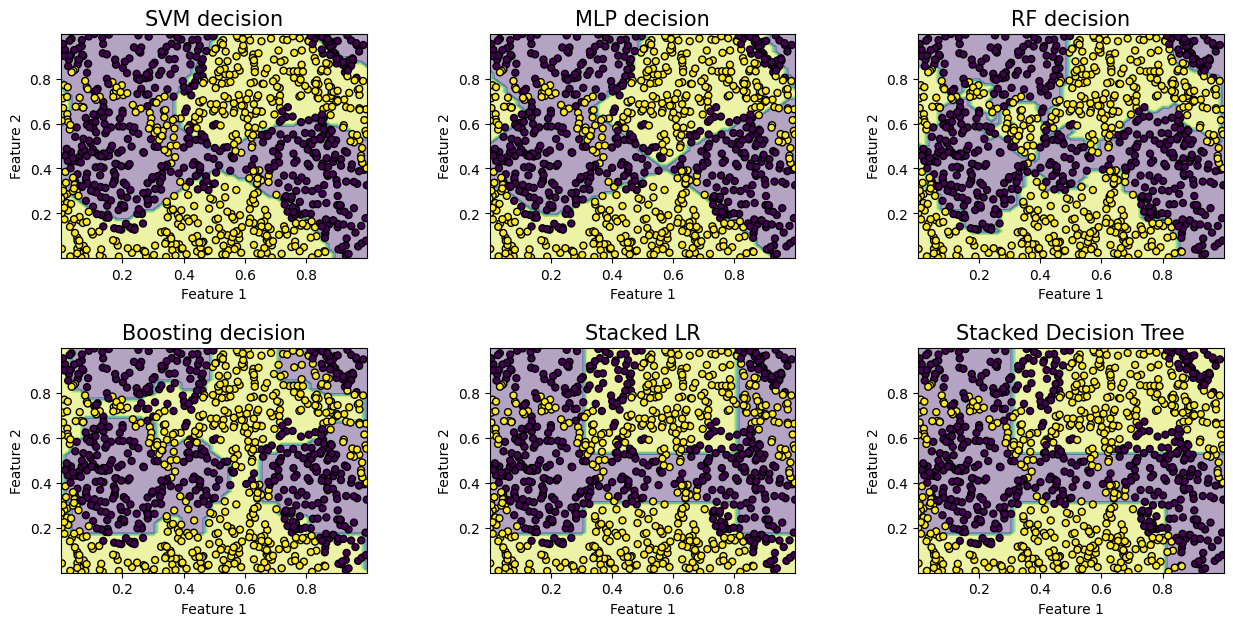

KNORAE score = 0.948
MCB score = 0.928
OLA score = 0.932
LCA = 0.855
SVM score = 0.798
MLP score = 0.794
RF score = 0.923
Boosting score = 0.795
Stacking LR score = 0.716
Staking Decision Tree = 0.732


<Figure size 640x480 with 0 Axes>

In [ ]:
# coding: utf-8
"""
====================================================================
Visualizing decision boundaries on the P2 problem
====================================================================
This example shows the power of dynamic selection (DS) techniques which can
solve complex non-linear classification near classifiers. It also compares
the performance of DS techniques with some baseline classification methods
such as Random Forests, AdaBoost and SVMs.
The P2 is a two-class problem, presented by Valentini, in which each class
is defined in multiple decision regions delimited by polynomial and
trigonometric functions:
    .. math:: \\begin{eqnarray}
        \\label{eq:problem1}
        E1(x) = sin(x) + 5 \\\\
        \\label{eq:problem2}
        E2(x) = (x - 2)^{2} + 1 \\\\
        \\label{eq:problem3}
        E3(x) = -0.1 \\cdot x^{2} + 0.6sin(4x) + 8 \\\\
        \\label{eq:problem4}
        E4(x) = \\frac{(x - 10)^{2}}{2} + 7.902
        \\end{eqnarray}
It is impossible to solve this problem
using a single linear classifier. The performance of the best possible
linear classifier is around 50\\%.
"""

###############################################################################
# Let's start by importing all required modules, and defining helper functions
# to facilitate plotting the decision boundaries:

!pip install deslib

import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Importing DS techniques
from deslib.dcs.ola import OLA
from deslib.dcs.lca import LCA
from deslib.dcs.mcb import MCB
from deslib.des.knora_e import KNORAE

#importing Stacking
from deslib.static import StackedClassifier

#importinh the Dataset
from deslib.util.datasets import make_P2


# Plotting-related functions
def make_grid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_classifier_decision(ax, clf, X, mode='line', **params):
    xx, yy = make_grid(X[:, 0], X[:, 1])

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    if mode == 'line':
        ax.contour(xx, yy, Z, **params)
    else:
        ax.contourf(xx, yy, Z, **params)
    ax.set_xlim((np.min(X[:, 0]), np.max(X[:, 0])))
    ax.set_ylim((np.min(X[:, 1]), np.max(X[:, 0])))


def plot_dataset(X, y, ax=None, title=None, **params):
    if ax is None:
        ax = plt.gca()
    ax.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25,
               edgecolor='k', **params)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    if title is not None:
        ax.set_title(title)
    return ax


###############################################################################
# Visualizing the dataset
# -----------------------
# Now let's generate and plot the dataset:


# Generating and plotting the P2 Dataset:
rng = np.random.RandomState(1234)
X, y = make_P2([1000, 1000], random_state=rng)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    random_state=rng)

print(X)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plot_dataset(X_train, y_train, ax=axs[0], title='P2 Training set')
plot_dataset(X_test, y_test, ax=axs[1], title='P2 Test set')

###############################################################################
# Evaluating the performance of dynamic selection methods
# -------------------------------------------------------
#
# We will now generate a pool composed of 5 Decision Stumps using AdaBoost.
#
# These are weak linear models. Each base classifier
# has a classification performance close to 50%.
pool_classifiers = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                                      n_estimators=5, random_state=rng)
pool_classifiers.fit(X_train, y_train)

ax = plot_dataset(X_train, y_train, title='Five Decision Stumps generated')
for clf in pool_classifiers:
    plot_classifier_decision(ax, clf, X_train)
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1))

plt.show()
plt.tight_layout()

###############################################################################
# Comparison with Dynamic Selection techniques
# --------------------------------------------
#
# We will now consider four DS methods: k-Nearest Oracle-Eliminate (KNORA-E),
# Dynamic Ensemble Selection performance (DES-P), Overall Local Accuracy (OLA)
# and Rank. Let's train the classifiers and plot their decision boundaries:

knora_e = KNORAE(pool_classifiers).fit(X_train, y_train)
mcb = MCB(pool_classifiers).fit(X_train, y_train)
ola = OLA(pool_classifiers).fit(X_train, y_train)
lca = LCA(pool_classifiers).fit(X_train, y_train)

# Plotting the Decision Border of the DS methods.
fig2, sub = plt.subplots(2, 2, figsize=(15, 10))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
titles = ['KNORA-Eliminate', 'MCB', 'Overall Local Accuracy (OLA)',
          'Local Class Accuracy (LCA)']

classifiers = [knora_e, mcb, ola, lca]
for clf, ax, title in zip(classifiers, sub.flatten(), titles):
    plot_classifier_decision(ax, clf, X_train, mode='filled', alpha=0.4)
    plot_dataset(X_test, y_test, ax=ax)
    ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
    ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))
    ax.set_title(title, fontsize=15)

# Setting figure to show
# sphinx_gallery_thumbnail_number = 3

plt.show()
plt.tight_layout()

###############################################################################
# Comparison to baselines
# -----------------------
#
# Let's now compare the results with four baselines: Support Vector Machine
# (SVM) with an RBF kernel; Multi-Layer Perceptron (MLP), Random Forest,
# Adaboost, and Stacking.

# Setting a baseline using standard classification methods
svm = SVC(gamma='scale', random_state=rng).fit(X_train, y_train)
mlp = MLPClassifier(max_iter=10000, random_state=rng).fit(X_train, y_train)
forest = RandomForestClassifier(n_estimators=10,
                                random_state=rng).fit(X_train, y_train)
boosting = AdaBoostClassifier(random_state=rng).fit(X_train, y_train)
stacked_lr = StackedClassifier(pool_classifiers=pool_classifiers,
                               random_state=rng)
stacked_lr.fit(X_train, y_train)

stacked_dt = StackedClassifier(pool_classifiers=pool_classifiers,
                               random_state=rng,
                               meta_classifier=DecisionTreeClassifier())
stacked_dt.fit(X_train, y_train)

###############################################################################

fig2, sub = plt.subplots(2, 3, figsize=(15, 7))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
titles = ['SVM decision', 'MLP decision', 'RF decision',
          'Boosting decision', 'Stacked LR', 'Stacked Decision Tree']
classifiers = [svm, mlp, forest, boosting, stacked_lr, stacked_dt]
for clf, ax, title in zip(classifiers, sub.flatten(), titles):
    plot_classifier_decision(ax, clf, X_test, mode='filled', alpha=0.4)
    plot_dataset(X_test, y_test, ax=ax)
    ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
    ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))
    ax.set_title(title, fontsize=15)

plt.show()
plt.tight_layout()

###############################################################################
# Evaluation on the test set
# --------------------------
#
# Finally, let's evaluate the baselines and the Dynamic Selection methods on
# the test set:

print('KNORAE score = {}'.format(knora_e.score(X_test, y_test)))
print('MCB score = {}'.format(mcb.score(X_test, y_test)))
print('OLA score = {}'.format(ola.score(X_test, y_test)))
print('LCA = {}'.format(lca.score(X_test, y_test)))
print('SVM score = {}'.format(svm.score(X_test, y_test)))
print('MLP score = {}'.format(mlp.score(X_test, y_test)))
print('RF score = {}'.format(forest.score(X_test, y_test)))
print('Boosting score = {}'.format(boosting.score(X_test, y_test)))
print('Stacking LR score = {}' .format(stacked_lr.score(X_test, y_test)))
print('Staking Decision Tree = {}' .format(stacked_dt.score(X_test, y_test)))